In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt

__author__ = 'Jo Schlemper;Mengye Lyu'

# from tensorflow.signal import fft, fft2d, ifft2d, ifft, ifftshift, fftshift
from numpy.fft import fft, fft2 as fft2d, ifft2 as ifft2d, ifft, ifftshift, fftshift
import numpy as np

def fftc(x, axis=- 1):
    ''' expect x as m*n matrix '''
    return fftshift(fft(ifftshift(x), axis=axis, norm="ortho"))


def ifftc(x, axis=- 1):
    ''' expect x as m*n matrix '''
    return fftshift(ifft(ifftshift(x), axis=axis, norm="ortho"))


def fft2c(x, axes=(- 2, - 1)):
    '''
    Centered fft
    Note: fft2 applies fft to last 2 axes by default
    :param x: 2D onwards. e.g: if its 3d, x.shape = (n,row,col). 4d:x.shape = (n,slice,row,col)
    :return:
    '''
    # axes = (len(x.shape)-2, len(x.shape)-1)  # get last 2 axes
    #axes = (-2, -1)  # get last 2 axes
    res = fftshift(fft2d(ifftshift(x), axes=axes, norm="ortho"))
    return res


def ifft2c(x, axes=(- 2, - 1)):
    '''
    Centered ifft
    Note: fft2 applies fft to last 2 axes by default
    :param x: 2D onwards. e.g: if its 3d, x.shape = (n,row,col). 4d:x.shape = (n,slice,row,col)
    :return:
    '''
    #axes = (-2, -1)  # get last 2 axes
    res = fftshift(ifft2d(ifftshift(x), axes=axes, norm="ortho"))
    return res

def sos(x, axis=- 1):
    '''
    root mean sum of squares, default on first dim
    '''
    res = np.sqrt(np.sum(np.abs(x)**2, axis=axis))
    return res
    
def rsos(x, axis=0):
    '''
    root mean sum of squares, default on first dim
    '''
    res = np.sqrt(np.sum(np.abs(x)**2, axis=axis))
    return res

def zpad(array_in, outshape):
    import math
    #out = np.zeros(outshape, dtype=array_in.dtype)
    oldshape = array_in.shape
    assert len(oldshape)==len(outshape)
    #kspdata = np.array(kspdata)
    pad_list=[]
    for iold, iout in zip(oldshape, outshape):
        left = math.floor((iout-iold)/2)
        right = math.ceil((iout-iold)/2)
        pad_list.append((left, right))

    zfill = np.pad(array_in, pad_list, 'constant')                     # fill blade into square with 0
    return zfill

def crop(img, bounding):
    import operator
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices].copy()


In [17]:
MB       = 2
R        = 2
calib_pd = 30

if MB == R:
    shifts = [i/(MB+1) for i in range(MB)] ## 当MB==R的时候，需要添加这种相位偏移
else:
    shifts = [i/MB for i in range(MB)] ## 普通相位偏移

paths = glob.glob('/home/jupyter-huangshoujin/raw_data/real/*T2*')

for path in paths:
    output_name  = path.split('/')[-1].split('.')[0]
    data         = np.load(path,allow_pickle=True).item()
    kspaces      = data['kspace']
    csms_001     = data['csm_001']
    csms_985     = data['csm_985']
    mask         = data['mask']
    N, nx, ny, c = kspaces.shape

    print(kspaces.shape)
    if c < 10:
        continue

    if N < 12:
        print('!!!!!!!'+output_name)
        continue
    
    N = 12
    print(output_name, kspaces.shape)

    if MB == 2 :
        slices_list  = [[i,N//MB*1+i] for i in range(0,N//MB,1)]
    elif MB == 3:
        slices_list  = [[i,N//MB*1+i,N//MB*2+i] for i in range(0,N//MB,1)]
    elif MB == 4:
        slices_list  = [[i,N//MB*1+i,N//MB*2+i,N//MB*3+i] for i in range(0,N//MB,1)]
    elif MB == 5:
        slices_list  = [[i,N//MB*1+i,N//MB*2+i,N//MB*3+i,N//MB*4+i] for i in range(0,N//MB,1)]
    else:
        assert 0
    for slice in slices_list:
        slice_kspace    = np.array([kspaces[i] for i in slice])
        slice_csm_001   = np.array([csms_001[i] for i in slice])
        slice_csm_985   = np.array([csms_985[i] for i in slice])
        slice_mask      = np.array([mask[i] for i in slice])
        img             = ifft2c(slice_kspace, axes=(1,2))
        readout_data    = np.zeros([nx*MB,ny,c],dtype=np.complex64)
        readout_mask    = np.zeros([nx*MB,ny],dtype=np.complex64)
        readout_csm_001 = np.zeros([nx*MB,ny,c],dtype=np.complex64)
        readout_csm_985 = np.zeros([nx*MB,ny,c],dtype=np.complex64)
        for i,shift in enumerate(shifts):
            shift                           = int(shift * nx)
            readout_data[i*nx:(i+1)*nx]     = np.roll(img[i],-shift,1)
            readout_mask[i*nx:(i+1)*nx]     = np.roll(slice_mask[i],-shift,1)
            readout_csm_001[i*nx:(i+1)*nx]  = np.roll(slice_csm_001[i],-shift,1)
            readout_csm_985[i*nx:(i+1)*nx]  = np.roll(slice_csm_985[i],-shift,1)
        if len(shifts) % 2 == 0:
            readout_data    = np.roll(readout_data,-(nx//2),0)
            readout_mask    = np.roll(readout_mask,-(nx//2),0)
            readout_csm_001 = np.roll(readout_csm_001,-(nx//2),0)
            readout_csm_985 = np.roll(readout_csm_985,-(nx//2),0)
        rss = sos(readout_data,-1)
        readout_data = fft2c(readout_data,axes=(0,1))

        acc_mask = np.zeros_like(readout_data)[:,:,0]
        acc_mask[0::MB, 0::R] = 1

        calib_mask = np.zeros_like(readout_data)[:,:,0]
        nx,ny      = calib_mask.shape
        pd = calib_pd // 2
        calib_mask[nx//2-pd:nx//2+pd, ny//2-pd:ny//2+pd] = 1
        
        samples = {
            'readout_data': (readout_data * acc_mask[:,:,None]).astype(np.complex64),
            'readout_calibration': (readout_data * calib_mask[:,:,None]).astype(np.complex64),
            'readout_mask': readout_mask.astype(np.complex64),
            'readout_csm':  readout_csm_001.astype(np.complex64),
            'readout_csm_985':  readout_csm_985.astype(np.complex64),
            'shifts': np.array(shifts),
            'slices': slice,
            'rss': rss.astype(np.float32),
            'MB': MB,
            'R' : R,
        }
        np.savez(f'data/fastMRI_MB{MB}_R{R}/{output_name}_MB{MB}_{R}_Slice{slice}.npz',data=samples)
        break
    break
        

(14, 384, 384, 4)
(16, 384, 384, 20)
file_brain_AXT2_200_2000389 (16, 384, 384, 20)


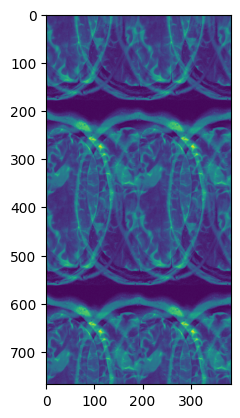

In [31]:
plt.imshow(sos(ifft2c(readout_data * acc_mask[:,:,None],axes=[0,1])))

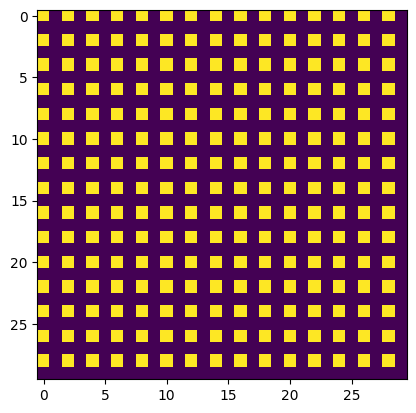

In [21]:
plt.imshow(abs(acc_mask)[:30,:30])

In [25]:
acc_mask = np.zeros_like(readout_data)[:,:,0]
acc_mask[0::MB, 0::R] = 1

In [26]:
mask1 = np.zeros_like(readout_data)[:,:,0]
mask1[0::MB] = 1

mask2 = np.zeros_like(readout_data)[:,:,0]
mask2[:,0::R] = 1



In [28]:
np.equal(acc_mask,(mask1*mask2)).sum()

294912

In [29]:
acc_mask.shape

(768, 384)

In [30]:
768 * 384

294912